In [17]:
import pickle
import os
import sys
from tqdm.auto import tqdm

sys.path.insert(0, '../olympus')
sys.path.insert(0, '../graphnet/src')
sys.path.insert(0, '../gnn_testbed')
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.1"

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from tqdm.auto import tqdm

import numpy as np
import seaborn as sns
import random
from jax import random
from jax import numpy as jnp

import torch
import torch_cluster
import torch_geometric
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from nemesis.event_generation.detector import make_line, generate_noise, Detector, make_triang
from nemesis.plotting import plot_event, plot_events, plot_confusion
from nemesis.data_handling.utils import event_labelling
from nemesis.node_features.feature_generation import generate_features
from nemesis.evaluation.evaluation import model_evaluation
from nemesis.evaluation.utils import count_parameters
from nemesis.models.train import train_model
from nemesis.models.gnns import Dynamic_class, DynEdge_modified

from torch.nn import Linear, Identity, ReLU, Softmax, Dropout, LeakyReLU
import torch.nn.functional as F
from torch_geometric.nn import knn_graph, TAGConv, global_mean_pool, global_max_pool, BatchNorm,  global_add_pool, EdgeConv, DynamicEdgeConv

from graphnet.models.gnn.dynedge import DynEdge
from graphnet.components.layers import DynEdgeConv
from graphnet.models.gnn.gnn import GNN
from graphnet.models.utils import calculate_xyzt_homophily, calculate_xyz_homophily_POne

%matplotlib inline


In [18]:
outpath = "."
plt.rcParams['figure.dpi'] = 100
if torch.cuda.is_available():
    print('CUDA')
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print('CPU')

CUDA


In [19]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
pmts_per_module = 16
pmt_cath_area_r = 75E-3 / 2 # m
module_radius = 0.21 # m
v_x = 0
efficiency = pmts_per_module * (pmt_cath_area_r)**2 * np.pi / (4*np.pi*module_radius**2)
det = make_triang(side_len, oms_per_line, dist_z, dark_noise_rate, rng, efficiency=efficiency, v_x=v_x, buoy_weight=30)
module_positions = jnp.asarray(det.module_coords)

In [4]:
#from multiprocessing import Pool
#import pickle
#import numpy as np
#import os
#file_idx = range(12)

def load_all_events(it):
    path_to_events = "/dss/pone/pone_events/all_events"
    load_array = ['cascades_15000ev_3.5-6.5_1.pickle',  'cascades_15000ev_3.5-6.5_2.pickle',
                  'cascades_15000ev_3.5-6.5_3.pickle',  'cascades_15000ev_3.5-6.5_4.pickle',
                  'stracks_15000ev_3.5-6.5_1.pickle',   'stracks_15000ev_3.5-6.5_2.pickle', 
                  'stracks_15000ev_3.5-6.5_3.pickle',   'stracks_15000ev_3.5-6.5_4.pickle', 
                  'tracks_15000ev_3.5-6.5_1.pickle',    'tracks_15000ev_3.5-6.5_2.pickle', 
                  'tracks_15000ev_3.5-6.5_3.pickle',    'tracks_15000ev_3.5-6.5_4.pickle']
            
    events, records = pickle.load(open(os.path.join(path_to_events, load_array[it]), "rb"))
    
    print(f'{it} loaded!')
    
    return events, records

In [5]:
cascades, cascade_records = load_all_events(0)
stracks, strack_records = load_all_events(4)        
tracks, track_records = load_all_events(8)

0 loaded!
4 loaded!
8 loaded!


In [ ]:
cascades1, cascade_records1 = load_all_events(0)        
cascades2, cascade_records2 = load_all_events(1)        
cascades3, cascade_records3 = load_all_events(2)        
cascades4, cascade_records4 = load_all_events(3)        
cascades = cascades1 + cascades2 + cascades3 + cascades4
cascade_records = cascade_records1 + cascade_records2 + cascade_records3 + cascade_records4

stracks1, strack_records1 = load_all_events(4)        
stracks2, strack_records2 = load_all_events(5)        
stracks3, strack_records3 = load_all_events(6)  
stracks4, strack_records4 = load_all_events(7)        
stracks = stracks1 + stracks2 + stracks3 + stracks4
strack_records = strack_records1 + strack_records2 + strack_records3 + strack_records4

tracks1, track_records1 = load_all_events(8)
tracks2, track_records2 = load_all_events(9)
tracks3, track_records3 = load_all_events(10)
tracks4, track_records4 = load_all_events(11)
tracks = tracks1 + tracks2 + tracks3 + tracks4
track_records = track_records1 + track_records2 + track_records3 + track_records4

In [6]:
print(len(cascades), len(cascade_records), len(stracks), len(strack_records), len(tracks), len(track_records))

15000 15000 15000 15000 15000 15000


In [7]:
cascade_labels, track_labels, strack_labels = event_labelling(track_records, strack_records, cascade_records, det_hull=det.outer_cylinder)

NameError: name 'cascade_labels' is not defined

In [ ]:
inside, outside = [], []
out_radius = det.outer_cylinder[0]
out_height = det.outer_cylinder[1]
for aa in range(60000):
    pos = track_records[aa].mc_info[0]["pos"]

    if pos[0]<out_radius and pos[0]>-out_radius and pos[1]<out_radius and pos[1]>-out_radius and pos[2]>-out_height/2 and pos[2]<out_height/2:
        #print(pos)
        inside.append(aa)
    else:
        outside.append(aa)
        
print(len(inside), len(outside), len(inside)+len(outside))

In [10]:
all_events = cascades + tracks + stracks
all_records = cascade_records + track_records + strack_records
all_labels = cascade_labels + track_labels + strack_labels
print(len(all_events), len(all_records), len(all_labels))

45000 45000 45000


In [11]:
data_array = generate_features(det, all_events, all_labels)

  0%|          | 0/45000 [00:00<?, ?it/s]

In [12]:
pickle.dump(data_array, open("/dss/pone/pone_events/features_arrays/data_array_180k_k8_Rout_right.pickle", "wb"))
#data_array = pickle.load(open("/dss/pone/pone_events/features_arrays/data_array_180k_k8_Rout___.pickle", "rb"))

In [12]:
import random
random.seed(81722)

indices = np.arange(len(data_array))
random.shuffle(indices)


shuffled_data = [data_array[i] for i in indices]
split_test = int(len(shuffled_data)*0.9)
training_data = shuffled_data[:split_test]
split_val = int(len(training_data)*0.9)
train_dataset = training_data[:split_val]
val_dataset = training_data[split_val:]

test_dataset = shuffled_data[split_test:]
test_indices = indices[split_test:]

In [24]:
import torch
from torch import Tensor
from torch.nn import Linear, Identity, ReLU, BatchNorm1d, LeakyReLU
import torch.nn.functional as F
from torch_geometric.nn import TAGConv, global_max_pool, BatchNorm, DynamicEdgeConv
from typing import Any, Dict, List, Optional, Union
from torch_geometric.typing import NoneType
from torch_scatter import scatter_max, scatter_mean, scatter_min, scatter_sum

from graphnet.models.gnn.gnn import GNN
from graphnet.components.layers import DynEdgeConv
from nemesis.models.utils import calculate_xyz_homophily_POne

In [25]:
class DynEdge_modified(GNN):
    def __init__(self, input_features, output_features, k = 15, features_subset = slice(12, 15), layer_size_scale=4):
        
        #Architecture configuration
        c = layer_size_scale
        l1, l2, l3, l4, l5, l6, l7 = (
            input_features, c * 16 * 2, c * 32 * 2, c * 64 * 2, c * 32 * 2, c * 512 * 2, output_features)
        
        #Base class constructor
        super().__init__(l1, l6)
        
        #First Layer
        self.conv_add1 = DynEdgeConv(
            torch.nn.Sequential(Linear(l1*2, l2),LeakyReLU(),Linear(l2, l3),LeakyReLU()),
            aggr="max",
            nb_neighbors=k,
            features_subset=features_subset)              
          
        #Second Layer  
        self.conv_add2 = DynEdgeConv(
            torch.nn.Sequential(Linear(l3*2, l4), LeakyReLU(), Linear(l4, l3), LeakyReLU()),
            aggr="add",
            nb_neighbors=k,
            features_subset=features_subset)
        
        #Third Layer
        self.conv_add3 = DynEdgeConv(
            torch.nn.Sequential(Linear(l3*2, l4),LeakyReLU(),Linear(l4, l3),LeakyReLU()),
            aggr="max",
            nb_neighbors=k,
            features_subset=features_subset)
        
        #Fourth Layer
        self.conv_cat1 = DynEdgeConv(
            torch.nn.Sequential(Linear(l3*2, l4),LeakyReLU(),Linear(l4, l3),LeakyReLU()),
            aggr="add",
            nb_neighbors=k,
            features_subset=features_subset)
        
        #Linear layers
        self.nn1 = Linear(l3*4 + l1, l4)
        self.nn2 = Linear(l4, l5)
        self.nn3 = Linear(4*l5 + 3, l6)
        self.lrelu = LeakyReLU()
        
        self.mlp = MLP([l6, l6/2, l6/8, l6/32, l7], dropout=0.5)
        
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        h_x, h_y, h_z = calculate_xyz_homophily_POne(x, edge_index, batch)
        
        global_means = scatter_mean(x, batch, dim=0)
        
        a, edge_index = self.conv_add1(x, edge_index, batch)
        b, edge_index = self.conv_add2(a, edge_index, batch)
        c, edge_index = self.conv_add3(b, edge_index, batch)
        d, edge_index = self.conv_cat1(c, edge_index, batch)
        
        #Skip cat
        x = torch.cat((x, a, b, c, d), dim=1)
        
        #Post-processing
        x = self.nn1(x)
        x = self.lrelu(x)
        x = self.nn2(x)
        
        #Aggregation across nodes
        a, _ = scatter_max(x, batch, dim=0)
        b, _ = scatter_min(x, batch, dim=0)
        c = scatter_sum(x, batch, dim=0)
        d = scatter_mean(x, batch, dim=0)
        
        #Cat aggr and scalar feats
        
        x = torch.cat((a, b, c, d, h_x, h_y, h_z), dim=1)
        
        #Readout
        
        x = self.lrelu(x)
        x = self.nn3(x)
        
        x = self.lrelu(x)
        
        return x     

In [23]:
model = DynEdge_modified(15, 4, k = 8, features_subset = slice(12, 15), layer_size_scale=4)
model.to(device)
count_parameters(model)

label_map = {0:"Contained cascade", 1:'Throughgoing Track', 2:"Starts in detector", 3:"Rest of events"}
model, all_trains_acc, all_vals_acc = train_model(model, train_dataset, val_dataset, label_map, k=15, epochs=250, patience=20, print_step=1, batch_size=200, lr=0.001)
plt.plot(np.linspace(0, len(all_trains_acc), len(all_trains_acc)), all_trains_acc, label="Training Accuracy")
plt.plot(np.linspace(0, len(all_vals_acc), len(all_vals_acc)), all_vals_acc, label="Validation Accuracy")
plt.legend()
plt.show()


NameError: name 'MLP' is not defined

In [7]:
test_loader = DataLoader(test_dataset, batch_size=250, shuffle=False)
fig1, miss_idx1, test_acc=model_evaluation(model, test_loader, all_events, all_records, all_labels, label_map, test_indices)
print('The test accuracy achieved is: ', test_acc)

NameError: name 'test_dataset' is not defined

In [18]:
path_to_models = "/dss/pone/nemesis_trained_models/"
#model = torch.load(os.path.join(outpath, "Dynmod_model_180k_R_75.pt"))
torch.save(model, os.path.join(outpath, "DynMod_model_180k_R_out_B250_107E_L8.pt"))

In [ ]:
for i,ii in enumerate(data_array):
    if i%1000 == 0:
        print(ii.y)

In [ ]:
import pickle
import os
import functools
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.8"
import sys
sys.path.insert(0, '../olympus')
sys.path.insert(0, '../hyperion')
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import product
import awkward as ak
import pandas as pd
from olympus.event_generation.photon_propagation.norm_flow_photons import make_generate_norm_flow_photons, make_nflow_photon_likelihood
from olympus.event_generation.photon_propagation.utils import sources_to_model_input
from nemesis.event_generation.detector import Detector, make_line, make_triang
from olympus.event_generation.event_generation import (
    generate_cascade,
    generate_cascades,
    simulate_noise,
    generate_realistic_track,
    generate_realistic_tracks,
    generate_realistic_tracks_test,
    generate_realistic_starting_tracks,)
from olympus.event_generation.lightyield import make_pointlike_cascade_source, make_realistic_cascade_source
from olympus.event_generation.utils import sph_to_cart_jnp, proposal_setup

#from olympus.plotting import plot_event
from hyperion.medium import medium_collections
from hyperion.constants import Constants
import jax
jax.config.update('jax_platform_name', 'cpu')
from jax import random
from jax import numpy as jnp
import json

path_to_config = "../hyperion/data/pone_config_optimistic.json"
config = json.load(open(path_to_config))["photon_propagation"]
ref_ix_f, sca_a_f, sca_l_f, _ = medium_collections[config["medium"]]

def c_medium_f(wl):
    """Speed of light in medium for wl (nm)."""
    return Constants.BaseConstants.c_vac / ref_ix_f(wl)

rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
pmts_per_module = 16
pmt_cath_area_r = 75E-3 / 2 # m
module_radius = 0.21 # m



In [3]:
from nemesis.data_handling.event_loading import load_test
det_test, cascades_test, cascade_records_test, tracks_test, track_records_test, stracks_test, strack_records_test = load_test()

0.005 speed loaded!
0.01 speed loaded!
0.015 speed loaded!
0.02 speed loaded!
0.025 speed loaded!
0.03 speed loaded!
0.035 speed loaded!
0.04 speed loaded!
0.045 speed loaded!
0.05 speed loaded!
0.055 speed loaded!
0.06 speed loaded!
0.065 speed loaded!
0.07 speed loaded!
0.075 speed loaded!
0.08 speed loaded!
0.085 speed loaded!
0.09 speed loaded!
0.095 speed loaded!
0.1 speed loaded!


In [5]:
cascade_labels_test, track_labels_test, strack_labels_test = event_labelling(track_records_test, strack_records_test, cascade_records_test, det_hull=det.outer_cylinder)
all_events_test = cascades_test + tracks_test + stracks_test
all_records_test = cascade_records_test + track_records_test + strack_records_test
all_labels_test = cascade_labels_test + track_labels_test + strack_labels_test

In [85]:
#pickle.dump(data_array, open("/dss/pone/pone_events/features_arrays/data_array_test_90k_k8_R75_v_x.pickle", "wb"))
#pickle.dump(all_records_test_info, open("/dss/pone/pone_events/features_arrays/all_records_test_90k_k8_R75_v_x.pickle", "wb"))

In [20]:
all_records_test = pickle.load(open("/dss/pone/pone_events/features_arrays/test_data_array/all_records_test_90k_k8_R75_v_x.pickle", "rb"))
test_energy_loaders = energy_division_loaders(det, all_events_test, all_labels_test, all_records_test, num_divisions=11, k=15, batch_size=250)

  0%|          | 0/90000 [00:00<?, ?it/s]

In [22]:
pickle.dump(test_energy_loaders, open("/dss/pone/pone_events/features_arrays/test_data_array/test_energy_loaders_90k_k15_Rout_B250_11divisions.pickle", "wb"))

In [23]:
model = torch.load("/dss/pone/nemesis_trained_models/Mar12/DynEdgeMod_180.0k_R100_k11_B200_L1_lr0.001.pt")
test_energy_loaders = pickle.load(open("/dss/pone/pone_events/features_arrays/test_data_array/test_energy_loaders_90k_k15_R75.pickle", "rb"))

KeyboardInterrupt: 

In [26]:
fig, test_accuracies, misscls_idx = energy_evaluation(model, test_energy_loaders)

  0%|          | 0/360.0 [00:00<?, ?it/s]

The accuracies of the different energy divisions are [42.7163268582437, 44.32343234323432, 45.761730063718865, 45.43923659837216, 47.46291959406714, 48.595367175948745, 51.477541371158395, 51.11607142857143, 48.40654608096469, 53.627180899908176]


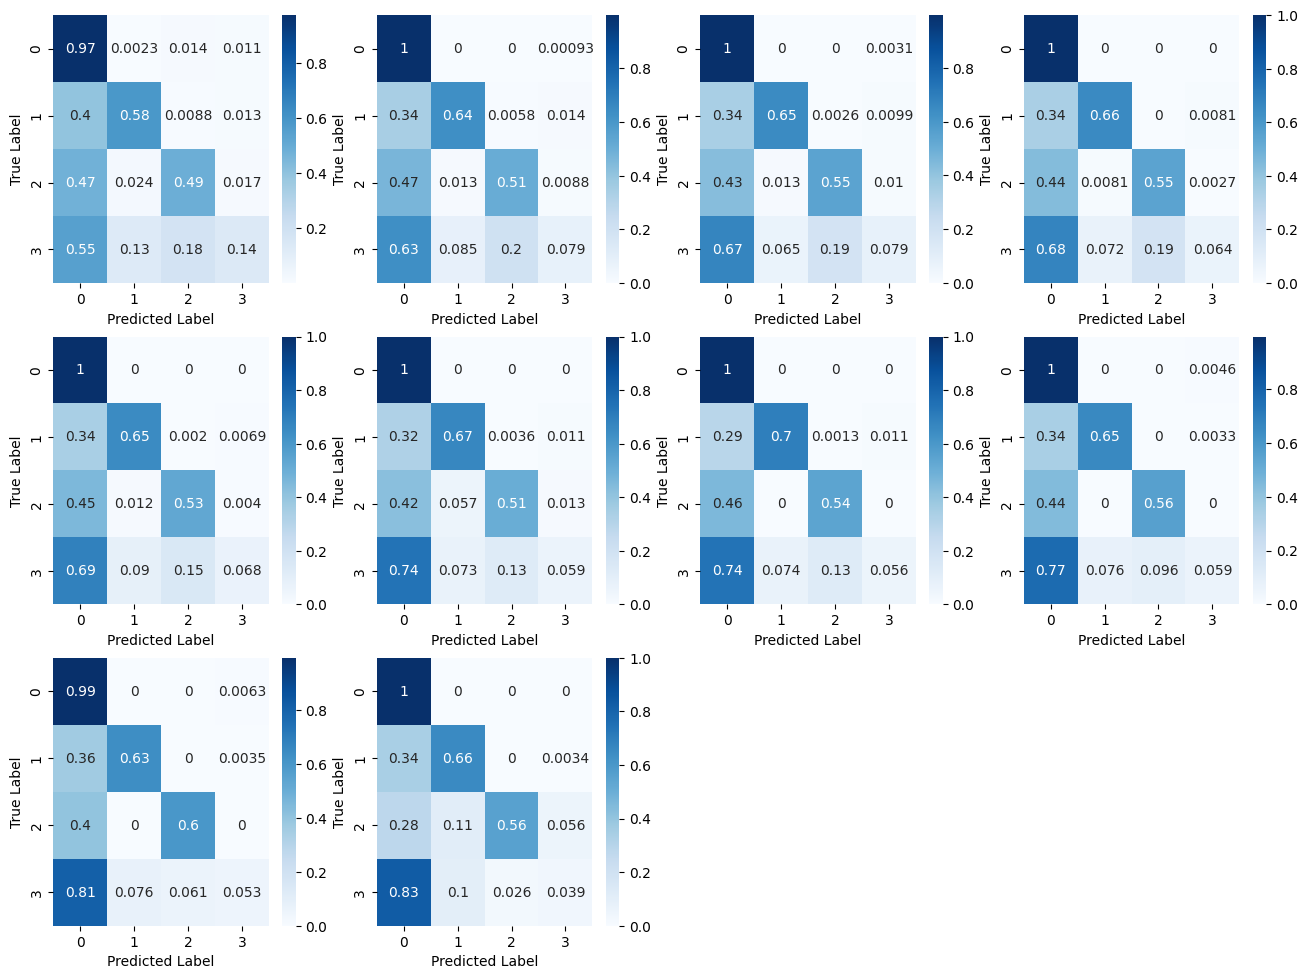

In [27]:
fig

## 